In [1]:
import poisson_atac as patac
from poisson_atac.utils import dataset_map_simple as dataset_map
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl

[rank: 0] Global seed set to 0
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/nasif12/home_if12/martensl/github_repos/scatac_poisson_private/poisson_atac/utils.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-poster")
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scvelo/settings.py:91: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead

In [2]:
scv.set_figure_params()
sns.set_style('whitegrid')

In [3]:
save_path = '/s/project/poisson_atac/anndata/metadata'

In [4]:
fig_path = '/s/project/poisson_atac/panels/revision2/Figure1'

# Save metadata for all four datasets

### Neurips

In [5]:
adata = patac.data.load_neurips(only_train=False)

In [6]:
adata.obs['n_peaks'] = adata.shape[1]

In [9]:
adata.obs.to_csv(os.path.join(save_path, f"{dataset_map['neurips']}_metadata.csv"))

### Satpathy

In [10]:
adata = patac.data.load_hematopoiesis()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [11]:
adata.obs["size_factor"] = adata.layers["counts"].sum(axis =1)
adata.obs['n_peaks'] = adata.shape[1]

In [12]:
adata.obs.to_csv(os.path.join(save_path, f"{dataset_map['satpathy']}_metadata.csv"))

### Fly

In [13]:
adata = patac.data.load_aerts()

In [14]:
adata.obs["size_factor"] = adata.layers["counts"].sum(axis =1)
adata.obs['n_peaks'] = adata.shape[1]

In [15]:
adata.obs.to_csv(os.path.join(save_path, f"{dataset_map['aerts']}_metadata.csv"))

### sci-ATAC-seq3

In [16]:
adata = sc.read('/lustre/groups/ml01/workspace/laura.martens/data/trapnell_sciATAC_fetal_tissue/all_tissues_filtered.h5ad', backed='r')

In [17]:
obs = adata.obs

In [18]:
obs["size_factor"] = adata.layers["counts"].sum(axis =1)
adata.obs['n_peaks'] = adata.shape[1]

In [19]:
obs.to_csv(os.path.join(save_path, f"{dataset_map['trapnell_old']}_metadata.csv"))

## Plot fragment count distribution

In [5]:
metadata = {key: pd.read_csv(os.path.join(save_path, f"{dataset_map[key]}_metadata.csv"), index_col=0).loc[:, ['size_factor', 'n_peaks']] for key in ['neurips', 'satpathy', 'aerts', 'trapnell']}

In [6]:
fragment_count = pd.concat(metadata).reset_index()

In [7]:
fragment_count = fragment_count.rename({'level_0': 'dataset'}, axis=1)

In [8]:
fragment_count.dataset = fragment_count.dataset.map(dataset_map)

In [9]:
fragment_count['mean_size_factor'] = fragment_count['size_factor']/fragment_count['n_peaks']

In [27]:
#dataset size
fragment_count.dataset.value_counts()

sci-ATAC-seq3 Human    720613
10x Fly                117613
10x Human Satpathy      63882
10x Human NeurIPS       62501
Name: dataset, dtype: int64

In [28]:
fragment_count['dataset_size'] = fragment_count.dataset.map(
    fragment_count.dataset.value_counts().apply(lambda x: f"{x:,.0f}")
)

In [30]:
fragment_count['legend'] = fragment_count['dataset'] + '\nn=' + fragment_count["dataset_size"]

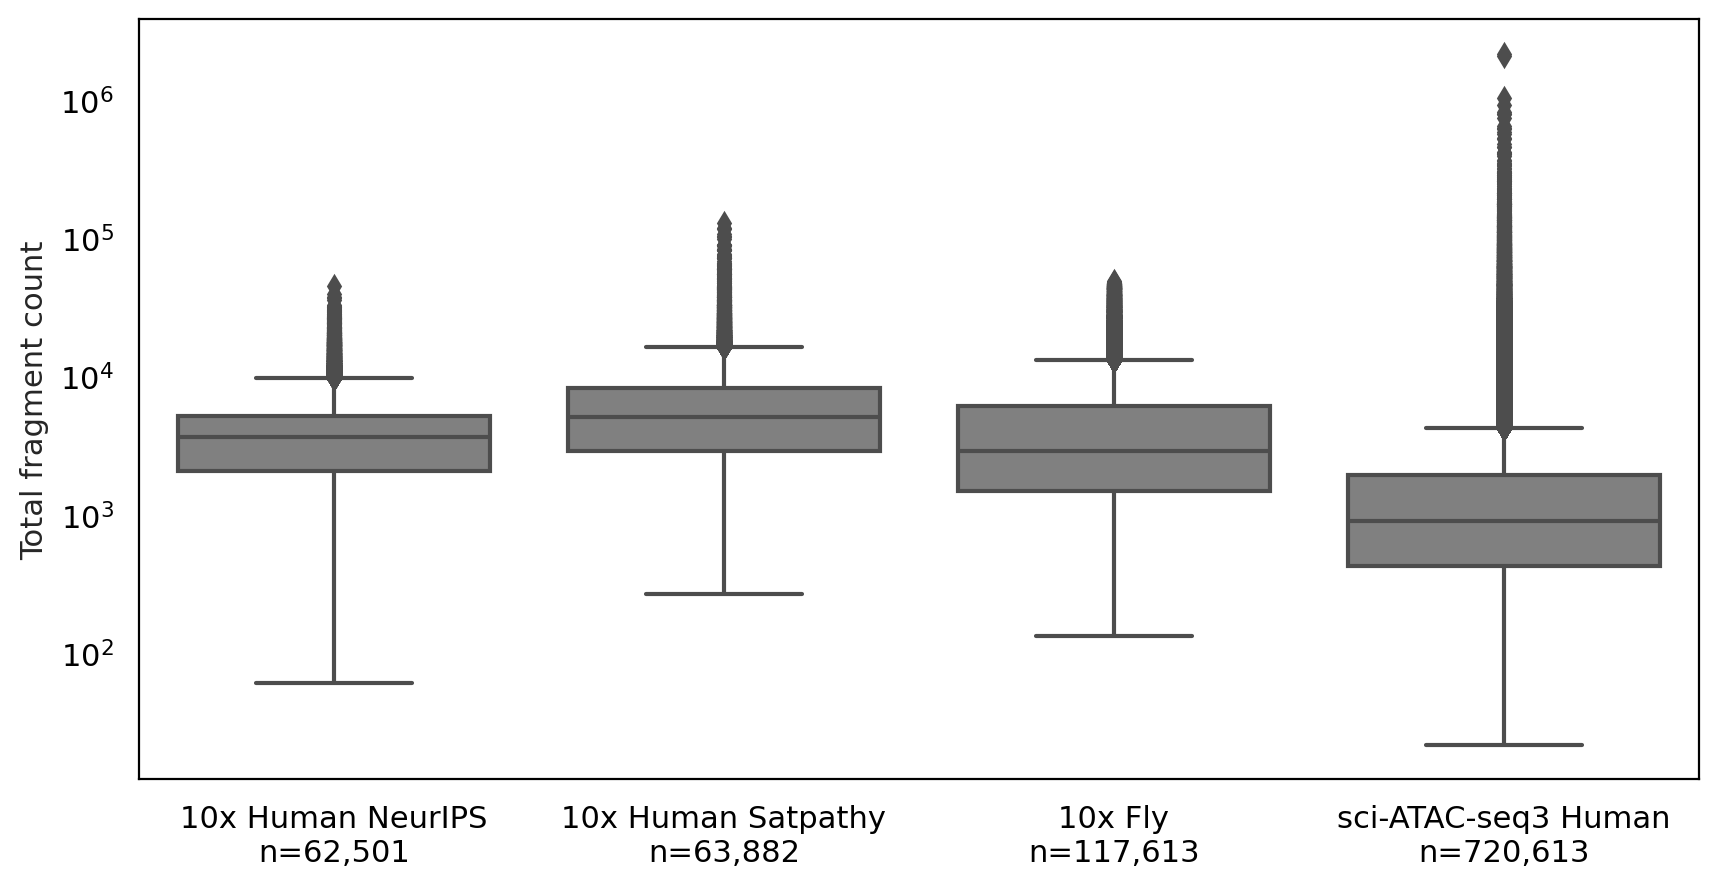

In [32]:
with mpl.rc_context(
    {"xtick.major.pad": 0, "xtick.minor.pad": 0, "ytick.major.pad": 0, "ytick.minor.pad": 0}
):
    sns.set_style("whitegrid")
    scv.set_figure_params()
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.boxplot(data=fragment_count, x='legend', y='size_factor', ax=ax, color='gray')
    ax.set(xlabel="", ylabel='Total fragment count', yscale='log')
    plt.savefig(os.path.join(fig_path, 'total_fragment_count.png'))
    plt.savefig(os.path.join(fig_path, 'total_fragment_count.pdf'))

## Plot mean fragment count distribution

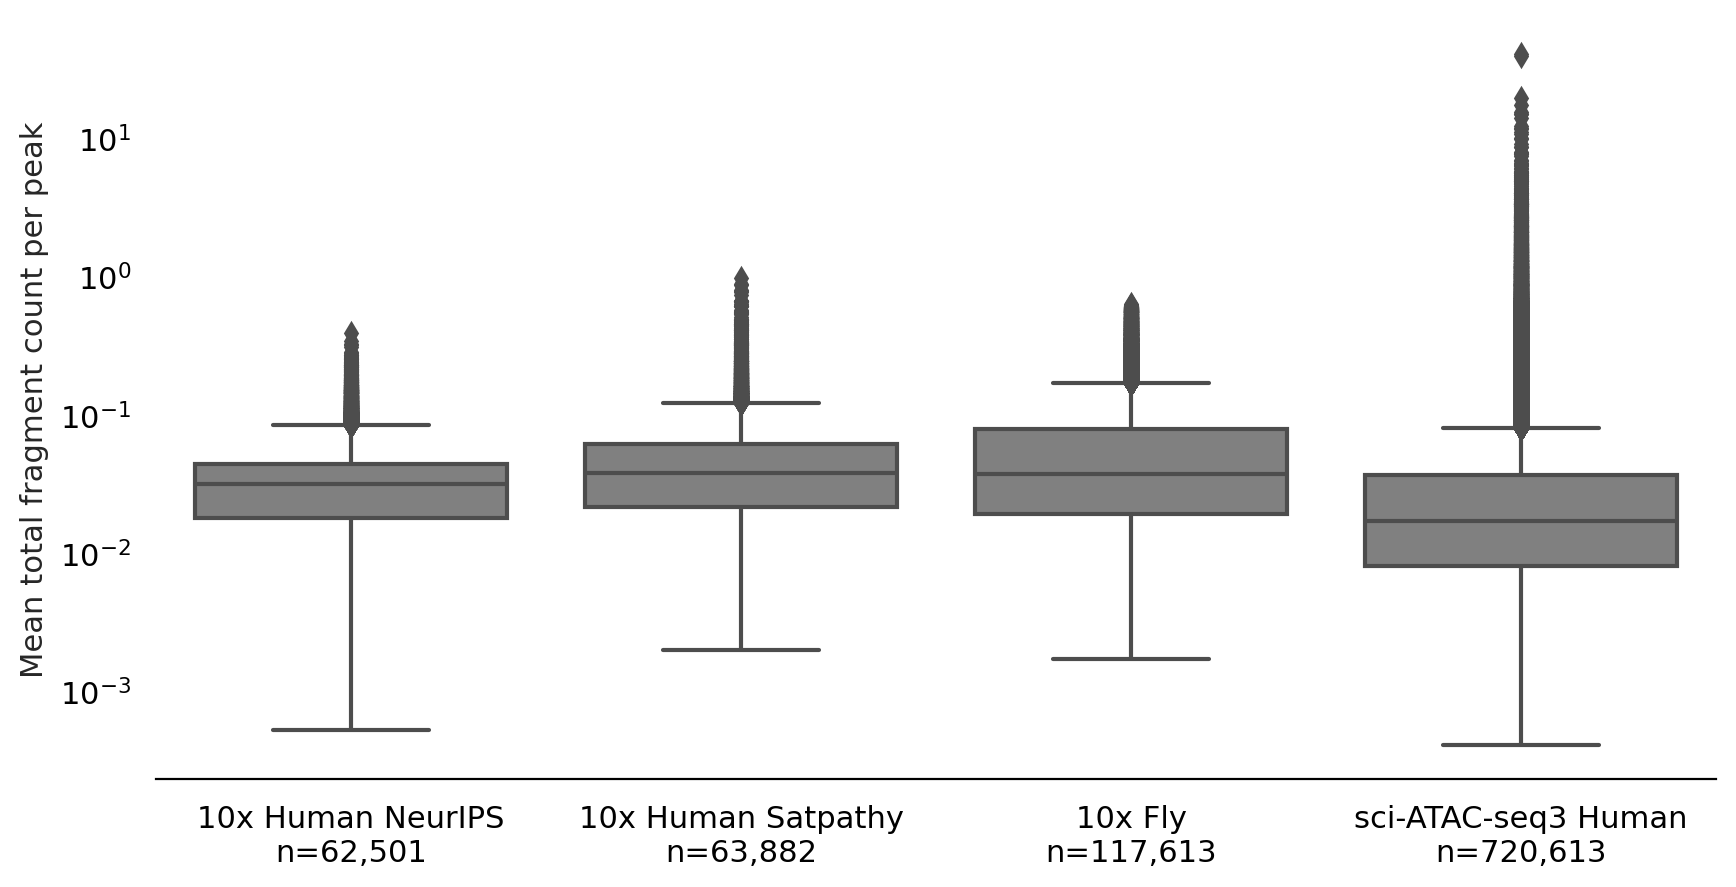

In [34]:
with mpl.rc_context(
    {"xtick.major.pad": 0, "xtick.minor.pad": 0, "ytick.major.pad": 0, "ytick.minor.pad": 0}
):
    sns.set_style("whitegrid")
    scv.set_figure_params()
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.boxplot(data=fragment_count, x='legend', y='mean_size_factor', ax=ax, color='gray')
    ax.set(xlabel="", ylabel='Mean total fragment count per peak', yscale='log')
    sns.despine(left=True)
    plt.savefig(os.path.join(fig_path, 'mean_total_fragment_count.png'))
    plt.savefig(os.path.join(fig_path, 'mean_total_fragment_count.pdf'))

# Save supplementary table

In [91]:
fragment_count = fragment_count.rename({'size_factor': 'Total_Fragment_Count', 'mean_size_factor': 'Mean_Total_Fragment_Count'}, axis=1)

In [92]:
summary = fragment_count.drop('n_peaks', axis=1).groupby('dataset').describe()

In [93]:
summary.columns = summary.columns.swaplevel()

In [94]:
summary = summary.drop('count', axis=1)

In [95]:
summary.columns = summary.columns.swaplevel()

In [96]:
summary['n_cells'] = fragment_count.groupby('dataset').size()

In [97]:
summary['n_peaks'] = fragment_count.groupby('dataset').first().n_peaks

In [107]:
summary = summary.loc[[dataset_map[key] for key in ['neurips', 'satpathy', 'aerts', 'trapnell_old']]]

In [108]:
summary.to_csv('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/panels/tables/dataset_summary.csv')

In [109]:
summary

Total_Fragment_Count                                      \
                                    mean          std    min     25%     50%   
dataset                                                                        
10x Human NeurIPS            4094.800307  2958.046422   62.0  2106.0  3696.0   
10x Human Satpathy           6301.975627  5109.367400  271.0  2899.0  5149.0   
10x Fly                      5018.921301  5856.603881  134.0  1506.0  2935.0   
sci-ATAC-seq3 Human          2106.901377  7390.499968   22.0   432.0   913.0   

                                        Mean_Total_Fragment_Count            \
                         75%        max                      mean       std   
dataset                                                                       
10x Human NeurIPS    5191.00    45699.0                  0.035152  0.025393   
10x Human Satpathy   8336.75   130461.0                  0.046993  0.038100   
10x Fly              6198.00    49562.0                  0.064462  0.075222   
sci-ATAC-seq3 Human  1974.00  2160033.0                  0.039706  0.139278   

                                                                        \
                          min       25%       50%       75%        max   
dataset                                                                  
10x Human NeurIPS    0.000532  0.018079  0.031728  0.044562   0.392300   
10x Human Satpathy   0.002021  0.021618  0.038396  0.062166   0.972835   
10x Fly              0.001721  0.019343  0.037697  0.079606   0.636569   
sci-ATAC-seq3 Human  0.000415  0.008141  0.017206  0.037201  40.706952   

                    n_cells n_peaks  
                                     
dataset                              
10x Human NeurIPS     62501  116490  
10x Human Satpathy    63882  134104  
10x Fly              117613   77858  
sci-ATAC-seq3 Human  720613   53063